In [11]:
%matplotlib inline
from IPython.display import clear_output
import time
from Environments.environments import train_envs, get_all_avail_envs, get_all_avail_test_envs, test_envs
from Agents.dqn_agent import DQN_Agent
from Agents.ppo_agent import PPO_Agent
# from Agents.ppo_exploration_agent import PPO_Exploration_Agent
from Models import fc, rnn
import matplotlib.pyplot as plt
import torch
import utils
from Curriculum_managers.random_curriculum import Random_Curriculum
import plotly.express as px
import gym
import os
from Agents.agent_utils import ObsWraper, ObsShapeWraper
import numpy as np
from pddlgym import pddlgym

from Environments.taxi import SingleTaxiEnv

In [12]:
def plot_res(vec, smooth=True):
    if smooth:
        fig = px.line(x=range(len(np.convolve(vec, np.ones(100)/100,mode='valid'))), y=np.convolve(vec, np.ones(100)/100, mode='valid'), title='Train rewards')
    else:
        fig = px.line(x=range(len(vec)), y=vec, title='Train rewards')
    fig.show()

In [13]:
device = utils.init_torch()

In [14]:
difficulty = "easy"

In [15]:
get_all_avail_test_envs("Maze", difficulty)

['Cluttered1MinigridMini',
 'Cluttered6MinigridMini',
 'Cluttered7MinigridMini',
 'Cluttered7MinigridMini_2',
 'EmptyRandomEnv6x6Minigrid',
 'EmptyRandomEnv15x15Minigrid',
 'MiniTwoRoomsEnvMinigrid']

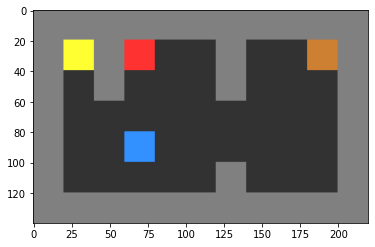

In [16]:
env = SingleTaxiEnv(size=5, agent_view_size=3, max_steps=300, n_clutter=20, n_agents=1, random_reset_loc=False)
env.init_from_vec([4,16,1,0, 0,5,2,7,22])
plt.imshow(env.render("rgb_array"))

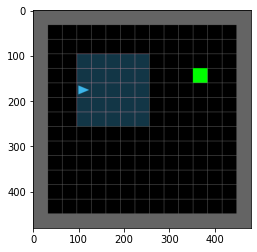

In [17]:
env = test_envs["Maze"][difficulty]["EmptyRandomEnv15x15Minigrid"]()
plt.imshow(env.render("rgb_array"))

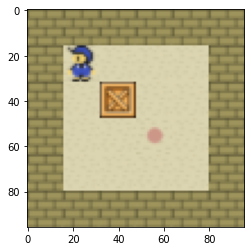

In [18]:
env = train_envs['Sokoban']()
n_actions = env.get_action_space().n
obs_shape = env.get_observation_space()
gen_obs_shape = env.get_generator_observation_space()
gen_action_dim = env.get_generator_action_space().n
plt.imshow(env.render())

In [19]:
def get_pddl_env(env_name, operators_as_actions=False, env_idx=0):
    env = pddlgym.make("PDDLEnv{}-v0".format(env_name.capitalize()), operators_as_actions=operators_as_actions)
    env.fix_problem_index(env_idx)
    obs = env.reset()
    # obs_space=obs.shape
    obs_space = None
    env_action_space = env.action_space
    actions = set()
    for i in range(1):
        actions.add(env.sample_action_space(obs))
    num_states = 600000
    setattr(env_action_space, "n", len(env.action_space._all_ground_literals))
    setattr(env, "actions", env.action_space._all_ground_literals)
    setattr(env, "num_states", num_states)
    setattr(env.env, "n", len(env.action_space._all_ground_literals))
    setattr(env.env, "actions", env.action_space._all_ground_literals)
    setattr(env.env, "num_states", num_states)
    return env,obs_space, env_action_space.n

In [68]:
env,obs_space, env_action_space = get_pddl_env("snake")
plt.imshow(env.render("rgb_array"))

AttributeError: 'NoneType' object has no attribute 'start'

In [65]:
env_action_space

84

In [30]:
# WITH RENDER:
#Sokoban
#slidetile - 56 actions calculated - not good
#rearrangement - 16 actions space - automatic jump is it good?
#minecraft - 64 actions spaces
#doors - 84 action spaces
# snake - pddl - bug


In [118]:
len(env.actions)

64

In [ ]:
env.step(0)
plt.imshow(env.render())

In [ ]:
env,obs_space, env_action_space = get_pddl_env("minecraft")
plt.imshow(env.render("rgb_array"))

In [117]:
len(env.actions)

64

In [ ]:
from pddlgym_planners.fd import FD
from pddlgym_planners.fd import PlanningFailure

lama_first_planner = FD(alias_flag="--alias lama-first")
state = env.get_state()
try: 
    plan =lama_first_planner(env.domain, state)
except PlanningFailure as e:
    if "Plan not found with FD" in str(e):
        plan = -1
    else:
        raise e
plan

In [ ]:
len(env.actions)

84

In [ ]:
env.step(50)
plt.imshow(env.render())

In [ ]:
env.actions

In [ ]:
# env.step(4)
env.render("rgb_array")

In [ ]:
len(env.actions)

64

In [ ]:
agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**3,num_parallel_envs=64, lr=0.0001 ,model=rnn.RNN)
train_rewards = agent.train_episodial(env, n_episodes=10000, max_episode_len=300)

In [ ]:
agent.train_episodial(env, n_episodes=10000, max_episode_len=300)

In [ ]:
plot_res(train_rewards)

In [ ]:
plot_res(train_rewards, smooth=True)

In [ ]:
agent.set_eval_mode()
for i in range(1):
    obs = env.reset()
    # break
    R = 0
    t = 0
    while True:
        # Uncomment to watch the behavior in a GUI window
        clear_output(wait=True)
        plt.imshow(env.render('rgb_array'))
        plt.show()
        # env.render(mode='rgb_array')
        # env.render()
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        print(action, r, done)

        R += r
        t += 1
        reset = t == 300
        time.sleep(0.01)
        if done or reset:
            break
    print('evaluation episode:', i, 'R:', R)